# **Land Type Classification using Sentinel-2 Satellite Images**

This project aims to automatically classify different types of land (such as
farms, bodies of water, urban areas, roads, and forests) from satellite imagery provided by the Sentinel-2 mission, which is an initiative run by the European Space Agency.

The outcome of the project will be a smart model that can look at satellite images and automatically label the type of land, which can save time, reduce manual effort, and provide insights at a national or global scale.




## **1- Problem Definition & Business Understanding**

Land classification from satellite images is a challenging yet crucial task. With the increasing availability of satellite data, especially multispectral imagery from sources like Sentinel-2, it's now possible to automatically identify what type of land is present in a given area (e.g., urban, agricultural, water, desert, etc.).

Manual land classification is time-consuming, expensive, and prone to human error. Automating this process using AI models offers a scalable, efficient, and more accurate alternative.

**Business Goal**: To develop a deep learning solution that classifies satellite images into meaningful land types, reducing manual effort and enabling timely, informed decisions.


## **2- Data Collection & Description**

For this project, we are using the EuroSAT dataset, which is based on imagery from the Sentinel-2 satellite provided by the European Space Agency (ESA). The dataset is publicly available on platforms like Kaggle and consists of pre-labeled images representing different land cover classes.

The EuroSAT dataset contains:

**Image size**: 64×64 pixels


**Number of classes: 10 land types**:
*   Annual Crop
*   Forest
*   Herbaceous Vegetation
*   Highway
*   Industrial
*   Pasture
*   Permanent Crop
*   Residential
*   River
*   Sea/Lake

In [4]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d apollo2506/eurosat-dataset
!unzip eurosat-dataset.zip -d eurosat_data

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
eurosat-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  eurosat-dataset.zip
replace eurosat_data/EuroSAT/AnnualCrop/AnnualCrop_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!pip install rasterio
!pip install tensorflow

In [6]:
# Standard Library
import os
from glob import glob

# Data Processing
import numpy as np
import pandas as pd

# Image Processing
from PIL import Image
import rasterio  # For geospatial raster data
import cv2  # OpenCV for computer vision
import albumentations as A  # Image augmentations
from albumentations import Compose, RandomRotate90, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

# Utilities
from tqdm import tqdm  # Progress bars

#Save and load the data
import joblib
import pickle
from tensorflow.keras.models import load_model

In [7]:
# Path to EuroSAT dataset
DATA_DIR = "/content/eurosat_data/EuroSATallBands"

In [8]:
# List and sort class names (each class is a folder)
classes = sorted(os.listdir(DATA_DIR))
print("Classes:", classes)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'label_map.json', 'test.csv', 'train.csv', 'validation.csv']


In [9]:
# Get all image paths with .tif extension inside class folders
image_paths = glob(os.path.join(DATA_DIR, "*/*.tif"))


# Create a DataFrame with image paths and their class labels
df = pd.DataFrame({
    "path": image_paths,
    "label": [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

In [10]:
def random_images(df, n=1):
    """
    Returns n random images per class from the dataframe.
    """
    return df.groupby("label").sample(n=n)

### **Sample Image's Spectral Bands**


*   Each Sentinel-2 image contains 13 spectral bands capturing different wavelengths, including visible, near-infrared (NIR), and shortwave infrared (SWIR) regions. This rich spectral information enables the model to effectively distinguish between various land types based on their unique spectral signatures.




In [11]:
band_names = [
    'B01 - Coastal Aerosol',
    'B02 - Blue',
    'B03 - Green',
    'B04 - Red',
    'B05 - Red Edge 1',
    'B06 - Red Edge 2',
    'B07 - Red Edge 3',
    'B08 - NIR',
    'B8A - Narrow NIR',
    'B09 - Water Vapor',
    'B10 - SWIR - Cirrus',
    'B11 - SWIR 1',
    'B12 - SWIR 2']


In [12]:
# Select one random image from the dataset using our utility function
sample_df = random_images(df, n=1)
sample_path = sample_df['path'].iloc[0]

# Open the image using rasterio to inspect its band structure
with rasterio.open(sample_path) as src:
    # Print total number of spectral bands in the image
    print(f"Number of Bands: {src.count}")

    # Loop through each band and display its data type and shape
    print("Data For Each Band:")
    for i in range(1, src.count + 1):
        print(f"  Band {i}: dtype={src.dtypes[i - 1]}, shape={src.read(i).shape}")

Number of Bands: 13
Data For Each Band:
  Band 1: dtype=uint16, shape=(64, 64)
  Band 2: dtype=uint16, shape=(64, 64)
  Band 3: dtype=uint16, shape=(64, 64)
  Band 4: dtype=uint16, shape=(64, 64)
  Band 5: dtype=uint16, shape=(64, 64)
  Band 6: dtype=uint16, shape=(64, 64)
  Band 7: dtype=uint16, shape=(64, 64)
  Band 8: dtype=uint16, shape=(64, 64)
  Band 9: dtype=uint16, shape=(64, 64)
  Band 10: dtype=uint16, shape=(64, 64)
  Band 11: dtype=uint16, shape=(64, 64)
  Band 12: dtype=uint16, shape=(64, 64)
  Band 13: dtype=uint16, shape=(64, 64)


### **Class Distribution**


*   The dataset is fairly balanced, with most classes around 9–11%.

*   SeaLake has the highest share (~13%), which might slightly bias the model.

*    Pasture is the least represented (~7.25%), so it may need augmentation to
     avoid underfitting.



In [13]:
# Count the number of images per class
class_counts = df['label'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Pie Chart
fig_pie = px.pie(class_counts,
                 names='Class',
                 values='Count',
                 title='Distribution of Images per Class',
                 hole=0.3)
fig_pie.show()

### **Top Spectral Bands per Land Type**
There is a clear distinction in band importance between land and water categories. This indicates that selecting specific bands—like SWIR and NIR for vegetation, and Coastal/Blue for water—can enhance model accuracy and reduce unnecessary data dimensions.

In [14]:
def band_stats(df, n_samples=20):
    band_stats = []
    sampled_df = random_images(df,n_samples)

    for _, row in sampled_df.iterrows():
        with rasterio.open(row['path']) as src:
            band_means = {}
            for i in range(1, src.count + 1):
                band_name = band_names[i - 1]
                band_data = src.read(i)
                band_means[band_name] = band_data.mean()

            band_stats.append({
                'label': row['label'],
                **band_means})

    return pd.DataFrame(band_stats)

In [15]:
band_df = band_stats(df)
grouped = band_df.groupby("label").mean().T

top_bands_named = grouped.apply(lambda x: x.sort_values(ascending=False).index[:6])
top_bands_named

label,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
0,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B12 - SWIR 2,B01 - Coastal Aerosol
1,B07 - Red Edge 3,B07 - Red Edge 3,B08 - NIR,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B07 - Red Edge 3,B02 - Blue
2,B08 - NIR,B08 - NIR,B07 - Red Edge 3,B08 - NIR,B08 - NIR,B08 - NIR,B08 - NIR,B08 - NIR,B08 - NIR,B03 - Green
3,B06 - Red Edge 2,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B10 - SWIR - Cirrus,B06 - Red Edge 2,B04 - Red
4,B10 - SWIR - Cirrus,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B10 - SWIR - Cirrus,B06 - Red Edge 2,B06 - Red Edge 2,B01 - Coastal Aerosol,B05 - Red Edge 1
5,B11 - SWIR 1,B01 - Coastal Aerosol,B11 - SWIR 1,B01 - Coastal Aerosol,B01 - Coastal Aerosol,B01 - Coastal Aerosol,B11 - SWIR 1,B11 - SWIR 1,B10 - SWIR - Cirrus,B07 - Red Edge 3


# **3- Exploratory Data Analysis (EDA)**

###  **Spectral Signature Visualization per Land Type**
To better understand the distinct spectral characteristics of various land cover types, we visualized a sample image from each class along with its average spectral signature across all bands. This helps identify how different land types (e.g., urban, forest, sea lake) reflect or absorb energy across the spectrum.

We used the natural RGB bands (Bands 4, 3, 2 – Red, Green, Blue) to render the images, and plotted their corresponding spectral signatures using the mean reflectance values across all Sentinel-2 bands.


In [16]:
def get_rgb_image(data):
    """
    Create a natural RGB image using Bands 4, 3, 2 (Red, Green, Blue).
    """
    rgb = np.dstack((data[3], data[2], data[1]))  # Bands are 0-indexed
    rgb = rgb.astype(np.float32)

    # Normalize between 0 and 1 using fixed scaling factor
    rgb /= 2750
    rgb = np.clip(rgb, 0, 1)

    return rgb

In [17]:
# Group the extracted band statistics by label
grouped = band_df.groupby('label')

# Iterate through each land type to display a sample image and its spectral signature
for landcover, group in grouped:
    image_path = df[df['label'] == landcover].sample(1)['path'].values[0]
    mean_signature = group[band_names].mean().values

    # Make The Image RGB
    with rasterio.open(image_path) as src:
        data = src.read()
        rgb_img = get_rgb_image(data)

    # Making Supplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f'{landcover}' ,'Spectral Signature'))

    fig.add_trace(go.Image(z=(rgb_img * 255).astype(np.uint8)),row=1, col=1)

    fig.add_trace(go.Scatter(
            x=band_names,
            y=mean_signature,
            mode='lines+markers',
            name=landcover,
            line=dict(width=2)),
        row=1, col=2
    )

    fig.update_layout(
        title=f'Spectral Signature Analysis - {landcover}',
        height=500,
        hovermode='x unified',
        showlegend=False
    )

    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_yaxes(showticklabels=False, row=1, col=1)

    fig.show()


### Image Pixel Analysis
#### Key Patterns
1. **Water Identification**
   - Ultra-low values in NIR/SWIR bands
   - B08 < 500 and B12 < 300 = Strong water signal

2. **Vegetation Health**
   - Forests show highest NIR (B08: ~2500)
   - Crops show strong red-edge (B05: 1500-1700)

3. **Urban Detection**
   - Highest SWIR1 values (B11: 1500+)
   - Consistent high reflectance across all bands

In [18]:
def pixel_data(df, num_samples=5, pixels_per_band=500):
    result=[]

    for label in df['label'].unique():
        class_data = df[df['label'] == label]
        samples = class_data.sample(num_samples)

        for i, row in samples.iterrows():
            with rasterio.open(row['path']) as img:
                bands = img.read()

                for band_num in range(bands.shape[0]):
                    pixels = bands[band_num].flatten()
                    sampled_pixels = np.random.choice(pixels, size=pixels_per_band)
                    band_name = band_names[band_num]

                    for val in sampled_pixels:
                        result.append({'label': label, 'band': band_name, 'value': float(val)})

    return pd.DataFrame(result)

In [19]:
df_pixels = pixel_data(df)

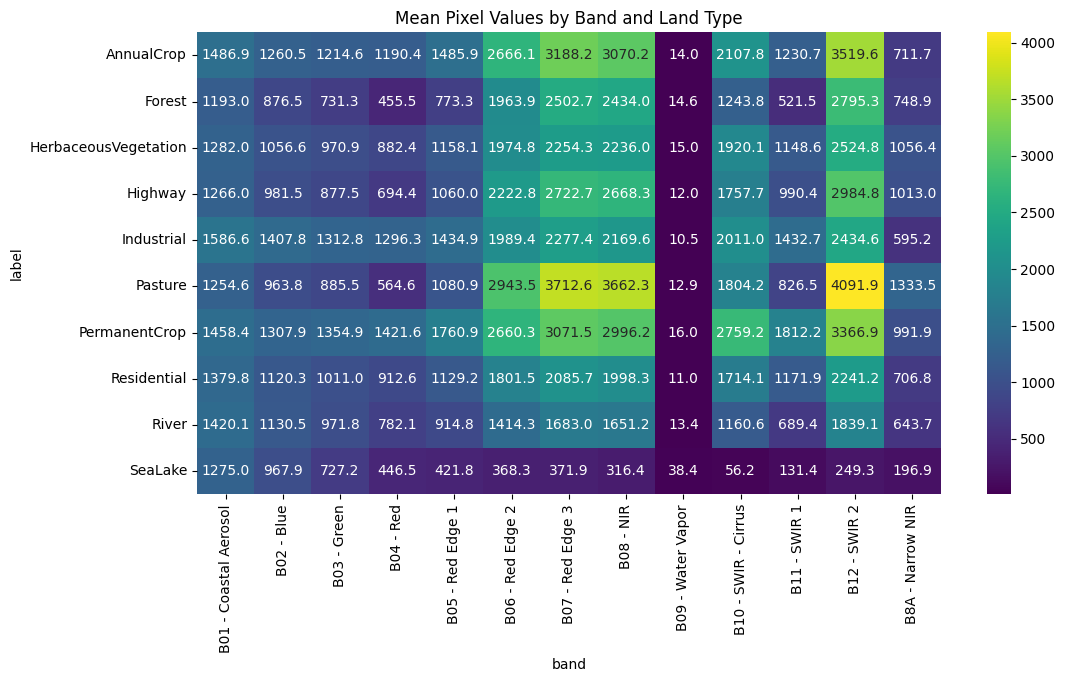

In [20]:
heatmap_data = df_pixels.groupby(['label', 'band'])['value'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
plt.title('Mean Pixel Values by Band and Land Type')
plt.show()

#  **4- Preprocessing and Feature Engineering**

## Adding NDVI, NDBI

### NDVI: Seeing Green 🌱

* **NDVI images** help us easily see areas with a lot of healthy plants (like forests and farms) in satellite pictures.

* It's a "greenness score" based on how plants reflect light, making vegetation stand out.

---

### NDBI: Finding Built-Up Areas 🏢

* **NDBI images** help us identify urban areas and man-made structures (like cities and roads) in satellite images.

* It's a "built-up score" based on how these surfaces reflect light, highlighting urban development.

In [21]:
Output_dir = '/content/processed_img'

def NDVI_NDBI(df, band_names, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_paths = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        path = row['path']
        label = row['label']
        with rasterio.open(path) as src:
            img = src.read().astype(np.float32)  # (C, H, W)
            img = np.transpose(img, (1, 2, 0))   # (H, W, C)
            # Compute NDVI and NDBI
            red = img[:, :, band_names.index('B04 - Red')]
            nir = img[:, :, band_names.index('B08 - NIR')]
            swir = img[:, :, band_names.index('B11 - SWIR 1')]
            ndvi = (nir - red) / (nir + red + 1e-6)
            ndbi = (swir - nir) / (swir + nir + 1e-6)
            ndvi = ndvi[..., np.newaxis]
            ndbi = ndbi[..., np.newaxis]
            img_new = np.concatenate([img, ndvi, ndbi], axis=-1)  # (H, W, C+2)
            # Save as .npy
            save_path = os.path.join(save_dir, os.path.splitext(os.path.basename(path))[0] + '_ndvi_ndbi.npy')
            np.save(save_path, img_new)
            new_paths.append(save_path)
    df_new = df.copy()
    df_new['npy_path'] = new_paths
    return df_new

In [22]:
df_15_bands = NDVI_NDBI(df, band_names, Output_dir)

100%|██████████| 27597/27597 [03:45<00:00, 122.64it/s]


### **Min-Max Scaling**
normalize each image **Min-Max Scaling**. This scales each band’s pixel values to a 0–1 range, which helps improve model performance.

In [23]:
SCALED_DIR = '/content/processed_scaled'
os.makedirs(SCALED_DIR, exist_ok=True)

scaled_paths = []

print('Saving scaled 15-band images (with NDVI/NDBI)')

for i, row in tqdm(df_15_bands.iterrows(), total=len(df_15_bands)):
    image_path = row['npy_path']  # Use the new npy_path
    label = row['label']

    data = np.load(image_path).astype(np.float32)  # (H, W, 15)

    # Apply Min-Max scaling to each band independently
    min_val = data.min(axis=(0, 1), keepdims=True)
    max_val = data.max(axis=(0, 1), keepdims=True)
    scaled_data = (data - min_val) / (max_val - min_val + 1e-6)
    scaled_data = np.clip(scaled_data, 0.0, 1.0)

    # Save the scaled image
    class_dir = os.path.join(SCALED_DIR, label)
    os.makedirs(class_dir, exist_ok=True)

    scaled_path = os.path.join(class_dir, os.path.basename(image_path))
    np.save(scaled_path, scaled_data)
    scaled_paths.append((scaled_path, label))

scaled_df = pd.DataFrame(scaled_paths, columns=['path', 'label'])

Saving scaled 15-band images (with NDVI/NDBI)


100%|██████████| 27597/27597 [02:01<00:00, 227.52it/s]


### **PCA**
This function takes a table of image file paths, reduces the number of bands in each image using PCA (Principal Component Analysis), and saves the new images with fewer bands. It gives you a new table with the paths to these new images.

In [24]:
def apply_pca_to_df(df, save_dir, n_components, n_sample_images=100):
    """
    Fits PCA on a random sample of images, then applies it to all images.
    - n_sample_images: number of images to use for PCA fitting.
    """
    os.makedirs(save_dir, exist_ok=True)
    # Randomly sample images for PCA fit
    sample_paths = df['path'].sample(n=min(n_sample_images, len(df)), random_state=42)
    X = []
    for path in tqdm(sample_paths, desc="Loading sample images for PCA"):
        img = np.load(path)  # (H, W, C)
        X.append(img.reshape(-1, img.shape[-1]))
    X = np.concatenate(X, axis=0)
    pca = PCA(n_components=n_components).fit(X)

    # Transform and save each image
    new_paths = []
    for path in tqdm(df['path'], desc="Applying PCA and saving images"):
        img = np.load(path)
        H, W, C = img.shape
        img_pca = pca.transform(img.reshape(-1, C)).reshape(H, W, n_components)
        save_path = os.path.join(save_dir, os.path.splitext(os.path.basename(path))[0] + f'_pca{n_components}.npy')
        np.save(save_path, img_pca)
        new_paths.append(save_path)
    df_new = df.copy()
    df_new['pca_path'] = new_paths
    return df_new, pca

In [25]:
PCA_DIR = '/content/final_processing'

final_df, pca = apply_pca_to_df(scaled_df, save_dir=PCA_DIR, n_components=8)

Applying PCA and saving images: 100%|██████████| 27597/27597 [01:15<00:00, 364.31it/s]


### **Image Augmentation**
*   Enhances model training by creating diverse image variations.
*   Class-Balanced: Prevents model bias      








In [26]:
def augment_image(image, label):
    # Random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Optionally: add more augmentations as needed
    return image, label

## **5. Training and Evaluation**

In [36]:
DATA_DIR = '/content/processed_npy'
BATCH_SIZE = 32
EPOCHS = 25
IMG_SIZE = (224, 224)
NUM_CLASSES = 10

In [28]:
label_encoder = LabelEncoder()

final_df['label_encoded'] = label_encoder.fit_transform(final_df['label'])

#### **Load NPY Images**

This function is used to load preprocessed `.npy` images from disk.

In [37]:
def load_npy_image(path):
    img = np.load(path).astype(np.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

#### **Process Image Paths**

In [30]:
def process_path(path, label):
    img = tf.numpy_function(load_npy_image, [path], tf.float32)
    img.set_shape((224, 224, 8))
    return img, label

#### **Create Dataset**

This function creates a tf.data.Dataset from the provided paths and labels.

In [31]:
def create_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(100)  # Shuffle for training to ensure randomness
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Batch and prefetch for performance
    return ds


#### **Split The Data**
split the data into:
- **70% for Training**: Used to train the model.
- **15% for Validation**: Used to tune the model and select the best one based on performance.
- **15% for Testing**: Used for final evaluation of the model.



In [33]:
train_df, temp_df = train_test_split(
    final_df, test_size=0.3, stratify=final_df['label_encoded'], random_state=42)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label_encoded'], random_state=42)

train_ds = create_dataset(train_df['pca_path'].values, train_df['label_encoded'].values, training=True)
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = create_dataset(val_df['pca_path'].values, val_df['label_encoded'].values, training=False)
test_ds = create_dataset(test_df['pca_path'].values, test_df['label_encoded'].values, training=False)


#### **Build ResNet Model**

defines the ResNet model using TensorFlow and Keras.

In [39]:
def build_resnet(input_shape=(224, 224, 8), num_classes=10):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights=None, input_tensor=inputs, pooling='avg')

    x = Dropout(0.3)(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

    model = Model(inputs, outputs)
    return model

#### **Compile and Train the Model**
compile and train the ResNet model with the training and validation datasets.

In [ ]:
model = build_resnet(input_shape=(224, 224, 8), num_classes=NUM_CLASSES)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(final_df['label_encoded']),
    y=final_df['label_encoded'])

class_weight_dict = dict(enumerate(class_weights))
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop, lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/25
387/387 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.4276 - loss: 2.2791 - val_accuracy: 0.4923 - val_loss: 1.9280 - learning_rate: 0.0010
Epoch 2/25
186/387 ━━━━━━━━━━━━━━━━━━━━ 2:50 849ms/step - accuracy: 0.6721 - loss: 1.1972

#### **Evaluation**

Evaluate the trained model's performance on the validation/test dataset.


In [ ]:
# Model Evaluation
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Training Accuracy: ", max(history.history['accuracy']))
print("Validation Accuracy: ", max(history.history['val_accuracy']))
print("Test Accuracy: ", np.mean(y_true == y_pred))

####Model Performance

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Get true labels from test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Predict on test dataset
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Class labels from LabelEncoder
class_labels = list(label_encoder.classes_)

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#true labels and predicted probabilities
y_score = model.predict(test_ds, verbose=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
n_classes = y_score.shape[1]
class_labels = label_encoder.classes_

#Binarize the true labels
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))

#Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Get class labels
class_labels = label_encoder.classes_

# Get one batch of images and labels
for x_test, y_test in test_ds.take(1):
    preds = model.predict(x_test)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = y_test.numpy().astype(int)

    # Let's show bands for the first image in the batch
    img = x_test[0].numpy()
    pred_label = class_labels[pred_labels[0]]
    true_label = class_labels[true_labels[0]]

    n_bands = img.shape[-1]
    plt.figure(figsize=(15, 6))
    for band in range(n_bands):
        plt.subplot(2, (n_bands + 1) // 2, band + 1)
        plt.imshow(img[:, :, band], cmap='gray')
        plt.title(f"Band {band + 1}")
        plt.axis('off')

    plt.suptitle(f"Pred: {pred_label} | True: {true_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

# **Saving the Model**

In [ ]:
model.save('ResNet.keras')